In [75]:
def modelCircle(b, c, d):
  #This funtion take 3 points as input and output the center coordinates and radius of the circle which going through given points
  temp = c[0]**2 + c[1]**2
  bc = (b[0]**2 + b[1]**2 - temp) / 2
  cd = (temp - d[0]**2 - d[1]**2) / 2
  det = (b[0] - c[0]) * (c[1] - d[1]) - (c[0] - d[0]) * (b[1] - c[1])

  if abs(det) < 1.0e-10:
    return None

  # Center of circle
  cx = (bc*(c[1] - d[1]) - cd*(b[1] - c[1])) / det
  cy = ((b[0] - c[0]) * cd - (c[0] - d[0]) * bc) / det

  radius = ((cx - b[0])**2 + (cy - b[1])**2)**.5

  return cx,cy,radius

def shrtDis(points,x,y,r):
    #this funtion caculate distance from given circle to giben points
    #points= numpy array which contain points
    #x,y = coordinate of center of the circle
    #r=raidus
    import numpy as np
    distances= np.array(abs(((points[:,0]-x)**2+(points[:,1]-y)**2)**0.5-r))
    return distances
def plotCiircle(Data,Datalst,color='r'):
    #this fuction plot the circle
    x,y,r=modelCircle(Datalst[Data[0]],Datalst[Data[1]],Datalst[Data[2]])
    c=plt.Circle((x,y),r,fill=False)
    c.set_color(color)
    return c

In [70]:
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
# np . random. seed ( 0 )
N = 100
half_n = N//2
r = 10
s = r /16
t = np . random. uniform(0 , 2*np . pi , half_n )
n = s*np . random. randn ( half_n )
x , y = ( r + n)*np . cos ( t ) , ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
m, b =-1, 2
x = np.linspace(-12, 12 , half_n )
y = m*x + b + s*np . random. randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) )


In [199]:
def ransacCircle(Data,N,t,count):
    #Data= Data set N=Number of iterations 
    # t= threshold distance count=threshold inlier count
    maximum_inlier_count=0
    
    for i in range(N):
        #selecting 3 points randomly
        rndPoints=np.random.choice(len(Data), size=3, replace=False)
        #modelCircle funtion output coordinates and radius of the circle which going through given points
        x,y,r=modelCircle(Data[rndPoints[0]],Data[rndPoints[1]],Data[rndPoints[2]])
        #shrDis funtion output the shortest distence between given point set and circle
        distanceLst=shrtDis(Data,x,y,r)
        if r>max(Data[:,1])*1.75:
            continue     #filter cicles which have very large radius
        inliers=Data[distanceLst<t]#finding inliers
        if len(inliers)-3 >count:  #check for threshold inlier count. -3 to remove three randomly slected points         
            shortest_Distance_Of_Inliers=shrtDis(inliers,x,y,r)
            mean_absolute_error = sum(shortest_Distance_Of_Inliers/shortest_Distance_Of_Inliers.size)
            if maximum_inlier_count < len(inliers)-3:#check for maximum inliers
                best_points=rndPoints
                error=mean_absolute_error
                maximum_inlier_count=len(inliers)-3
                best_inlier_set=inliers
            elif maximum_inlier_count== len(inliers) -3 and error>mean_absolute_error: #if maximum number of inliers is similer to current inlier count then check for mean
                
                best_points=rndPoints
                error=mean_absolute_error
                best_inlier_set=inliers
        
    
                
    return best_points,best_inlier_set

    

47
46


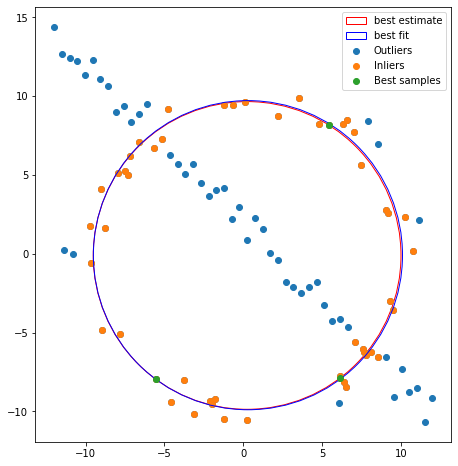

In [201]:
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
ranL,bestInlier=ransacCircle(X,500,1,35)          
c=plotCiircle(ranL,X)
fig,ax=plt.subplots(figsize=(8,8))
ax.set_aspect( 1 )
ax.add_artist( c )
p1=ax.scatter(X[:,0],X[:,1])
p2=ax.scatter(bestInlier[:,0],bestInlier[:,1])
bestfit,inl=ransacCircle(bestInlier,100,1,len(bestInlier)/1.2)
c2=plotCiircle(bestfit,bestInlier,'b')
ax.add_artist( c2 )
Y=np.vstack((X[ranL[0]],X[ranL[1]],X[ranL[2]]))
p3=ax.scatter(Y[:,0],Y[:,1])
plt.legend(handles=[c, c2,p1,p2,p3],labels=['best estimate','best fit','Outliers','Inliers','Best samples'])
plt.show()

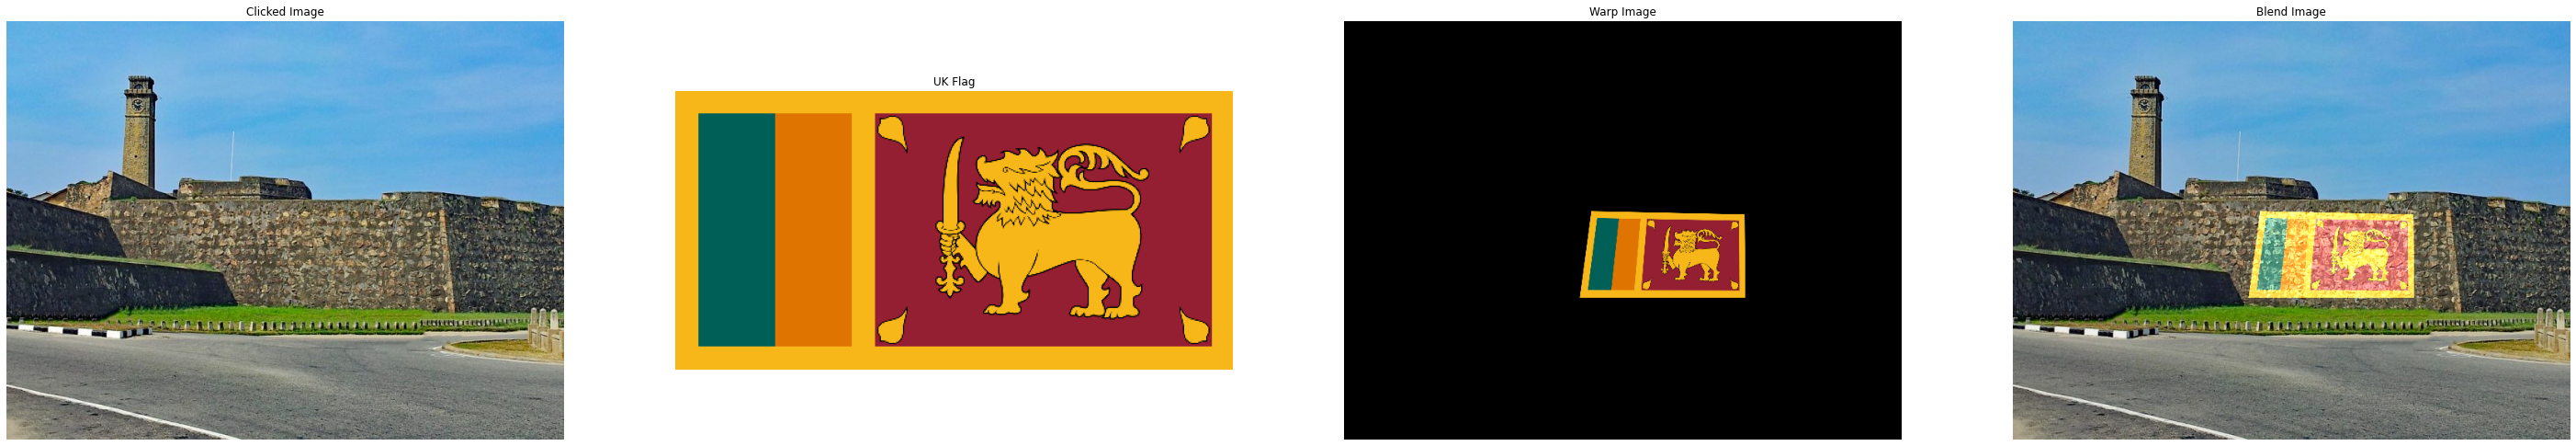

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

count = 0
points = []
width = 0
height = 0

def mousePoints(event, x, y, flags, params):
    global count
    global points
    if count < 4:
        if event == cv.EVENT_LBUTTONDOWN:
            points.append((x, y))
            count += 1
    return None

def getshape(pts):
    global width
    global height
    width = (abs(pts[0][0] - pts[1][0]) + abs(pts[2][0] - pts[3][0]))//2
    height = (abs(pts[0][1] - pts[2][1]) + abs(pts[1][1] - pts[3][1]))//2

    return width, height

img1 = cv.imread(r'galle fort.jpg', cv.IMREAD_COLOR)
img2 = cv.imread(r'Flag_of_Sri_Lanka.png', cv.IMREAD_REDUCED_COLOR_4)
img3 = img1

cv.imshow("original image", img1)
cv.setMouseCallback("original image", mousePoints)
cv.waitKey(0)
cv.destroyAllWindows()

pts_src = np.array([[0,0], [img2.shape[1],0], [0, img2.shape[0]], [img2.shape[1],img2.shape[0]]]) 
pts_dst = np.array(points)
shape0, shape1 = getshape(points)


h , status = cv.findHomography(pts_src, pts_dst,cv.RANSAC, 5.0)
im_out = cv.warpPerspective(img2, h, (img1.shape[1], img1.shape[0]))
blend_image = cv.addWeighted(img1, 0.95, im_out, 0.8, 0.0)


fig, ax = plt.subplots(1,4, figsize = (50,10))
ax[0].imshow(cv.cvtColor(img3, cv.COLOR_BGR2RGB))
ax[0].set_title("Clicked Image")
ax[0].axis('off') 
ax[1].imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
ax[1].set_title("UK Flag")
ax[1].axis('off') 
ax[2].imshow(cv.cvtColor(im_out, cv.COLOR_BGR2RGB))
ax[2].set_title("Warp Image")
ax[2].axis('off')
ax[3].imshow(cv.cvtColor(blend_image, cv.COLOR_BGR2RGB))
ax[3].set_title("Blend Image")
ax[3].axis('off')
plt.show() 

1.0


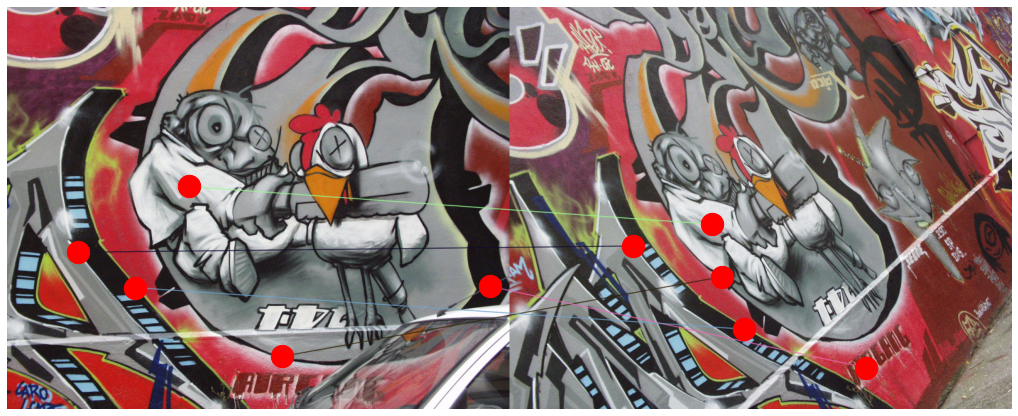

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

img1 = cv.imread(r"graf\img1.ppm", cv.IMREAD_COLOR)
img2 = cv.imread(r"graf\img4.ppm", cv.IMREAD_COLOR)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

sift = cv.SIFT_create(contrastThreshold=0.08,edgeThreshold =5,sigma = 0.5)

keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None) 
keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)

bf = cv.BFMatcher(cv.NORM_L1, crossCheck = True)

matches = bf.match(descriptors_1, descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

x=np.array([np.array(keypoints_1[x.queryIdx].pt) for x in matches])
x=np.c_[x,np.ones(len( matches))]
print(x[0][2])
img3 = cv.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[50:55], None, flags =2)
fig, ax = plt.subplots(1,1, figsize = (18, 18))
plt.imshow(img3)
for i in range(50,55):
    plt.scatter(keypoints_1[matches[i].queryIdx].pt[0], keypoints_1[matches[i].queryIdx].pt[1], s=500, c='red', marker='o')
    plt.scatter(keypoints_2[matches[i].trainIdx].pt[0]+800, keypoints_2[matches[i].trainIdx].pt[1], s=500, c='red', marker='o')
plt.axis('off')
plt.show()


In [25]:
A = []
ccp=[[243,195],[451,515],[164,200],[684,107]]
ppc=[[347,228],[444,558],[312,233],[494,190]]
for i in range(0, len(matches[:4])):
    u, v = ppc[i][0],ppc[i][1]
    x, y = ccp[i][0],ccp[i][0]
    A.append([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
    A.append([0, 0, 0, x, y, 1, -v*x, -v*y, -v])
A = np.asarray(A)
U, S, Vh = np.linalg.svd(A)
L = Vh[-1,:] / Vh[-1,-1]
H = L.reshape(3, 3)
H



In [10]:
import cv2
import numpy as np
import getopt
import sys
import random
def calcHomography(correspondences):
    #loop through correspondences and create assemble matrix
    aList = []
    for corr in correspondences:
        Source = np.matrix([corr.item(0), corr.item(1), 1])
        Traget = np.matrix([corr.item(2), corr.item(3), 1])
        row1 = [-Traget.item(2) *Source.item(0), -Traget.item(2) *Source.item(1), -Traget.item(2) *Source.item(2), 0, 0, 0,
              Traget.item(0) *Source.item(0), Traget.item(0) *Source.item(1), Traget.item(0) *Source.item(2)]
        row2 = [0, 0, 0, -Traget.item(2) *Source.item(0), -Traget.item(2) *Source.item(1), -Traget.item(2) *Source.item(2),
              Traget.item(1) *Source.item(0), Traget.item(1) *Source.item(1), Traget.item(1) *Source.item(2)]
        
        aList.append(row1)
        aList.append(row2)

    matrixA = np.matrix(aList)

    #svd composition
    u, s, v = np.linalg.svd(matrixA)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize and now we have h
    h = (1/h.item(8)) * h
    return h


#
#Calculate the geometric distance between estimated points and original points
#
def geometricDistance(correspondence, h):

    Source = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimateTraget = np.dot(h,Source)
    estimateTraget = (1/estimateTraget.item(2))*estimateTraget

    Traget = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = Traget - estimateTraget
    return np.linalg.norm(error)


#
#Runs through ransac algorithm, creating homographies from random correspondences
#
def ransac(corr, thresh):
    maxInliers = []
    finalH = None
    for i in range(1000):
        #find 4 random points to calculate a homography
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))

        #call the homography function on those points
        h = calcHomography(randomFour)
        inliers = []

        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            if d < 5:
                inliers.append(corr[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
        #print ("Corr size: ", len(corr), " NumInliers: ", len(inliers), "Max inliers: ", len(maxInliers))

        if len(maxInliers) > (len(corr)*thresh):
            break
    return finalH, maxInliers

def ransac23(corr, thresh,N,distance=1.5):
    maxInliers = 0
    finalH = None
    for i in range(N):
        #find 4 random points to calculate a homography
        rndPoints=np.random.choice(len(corr), size=4, replace=False)
        randomFour = np.array([corr[x] for x in rndPoints])

        #call the homography function on those points
        h = calcHomography(randomFour)
        
        d=np.array([geometricDistance(x,h)<distance for x in corr])
        if np.count_nonzero(d==1) > maxInliers:
            maxInliers = np.count_nonzero(d==1)
            finalH = h
        #print ("Corr size: ", len(corr), " NumInliers: ", len(inliers), "Max inliers: ", len(maxInliers))

        
    return finalH, maxInliers

In [67]:


#find features and keypoints
correspondpoints = []
img1 = cv.imread(r"graf\img1.ppm", cv.IMREAD_COLOR)
img2 = cv.imread(r"graf\img5.ppm", cv.IMREAD_COLOR)
img3 = cv.imread(r"graf\img5.ppm", cv.IMREAD_COLOR)

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)

sift = cv.SIFT_create()


keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None) 
keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)
keypoints_3, descriptors_3 = sift.detectAndCompute(img3, None)

bf = cv.BFMatcher(cv.NORM_L1, crossCheck = True)

matches = bf.match(descriptors_1, descriptors_2)
for match in matches:
    (x1, y1) = keypoints_1[match.queryIdx].pt
    (x2, y2) = keypoints_2[match.trainIdx].pt
    correspondpoints.append([x1,y1,x2,y2])
corrs = np.matrix(correspondpoints)

        #run ransac algorithm
finalH, inliers = ransac23(corrs, 0.3,100)


matches = bf.match(descriptors_2, descriptors_3)
for match in matches:
    (x1, y1) = keypoints_2[match.queryIdx].pt
    (x2, y2) = keypoints_3[match.trainIdx].pt
    correspondpoints.append([x1,y1,x2,y2])
corrs = np.matrix(correspondpoints)

        #run ransac algorithm
finalH2, inliers = ransac23(corrs, 0.3,100)

print(finalH)
'''   6.2544644e-01   5.7759174e-02   2.2201217e+02
   2.2240536e-01   1.1652147e+00  -2.5605611e+01
   4.9212545e-04  -3.6542424e-05   1.0000000e+00'''

[[-4.21937749e-01 -4.56851895e-01  3.95040299e+02]
 [-1.93221640e-01 -2.26311933e-01  1.96476095e+02]
 [-7.22993410e-04 -1.40416680e-03  1.00000000e+00]]


'   6.2544644e-01   5.7759174e-02   2.2201217e+02\n   2.2240536e-01   1.1652147e+00  -2.5605611e+01\n   4.9212545e-04  -3.6542424e-05   1.0000000e+00'

((-0.5, 799.5, 639.5, -0.5),
 (-0.5, 799.5, 639.5, -0.5),
 (-0.5, 799.5, 799.5, -0.5))

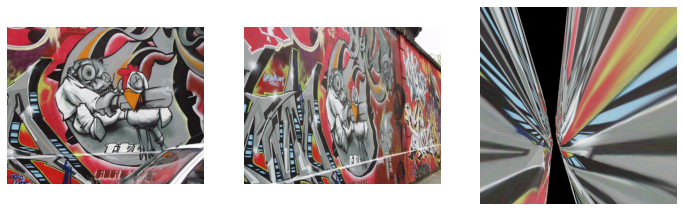

In [56]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

im1 = cv.imread(r"./graf/img1.ppm",cv.IMREAD_ANYCOLOR)
im4 = cv.imread(r"./graf/img5.ppm",cv.IMREAD_ANYCOLOR)
im1=cv.cvtColor(im1,cv.COLOR_BGR2RGB)
im4=cv.cvtColor(im4,cv.COLOR_BGR2RGB)

H=finalH


#imlto4 = cv.warpPerspective(im4,np.linalg.inv(H),(800,800))
imlto4 = cv.warpPerspective(im4,H,(800,800))

fig,ax =plt.subplots(1,3,figsize=(12,12))
ax[0].imshow(im1)
ax[1].imshow(im4)
ax[2].imshow(imlto4)
ax[0].axis('off'),ax[1].axis('off'),ax[2].axis('off')


##Part 333